In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pickle
import os

In [ ]:
#audio = tfio.audio.AudioIOTensor('../DoReMir/initslurtest_vn/initslurtest_vn_wav/slurtest01.wav')
sr = 44100

In [ ]:
# Conversion to tensor
audio_tensor = tf.squeeze(audio[:], axis=[-1])
audio_tensor = tf.cast(audio_tensor, tf.float32)/np.max(audio_tensor)

In [ ]:
# Automatic trimming
position = tfio.audio.trim(audio_tensor, axis=0, epsilon=0.1)
print(position)

START = position[0]
END = position[1]
print(START, END)

processed = audio_tensor[START:END]

fig, axs = plt.subplots(2,1, figsize=(20,2))
[ax.plot(tensor.numpy()) for ax, tensor in zip(axs, [audio_tensor, processed])]

In [ ]:
def multi_window_spectrogram(audio_tensor, win_sizes, hop_size, mels, fmin, fmax, sr=44100):
    spects = []
    for win_size in win_sizes:
        spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=win_size, window=win_size, stride=hop_size)
        # Should NFFT be same as window size always?
        mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sr, mels=mels, fmin=fmin, fmax=fmax)
        dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
        spects.append(dbscale_mel_spectrogram)
    return spects

In [10]:
HOP = 440
MELS = 80
sr = 44100

In [ ]:
spects = multi_window_spectrogram(audio_tensor, [1024, 2048, 4096], HOP, MELS, 27.5, 16000.0)

In [2]:
# Load from file
with open('../datasets/beatboxset1/spectrogram/callout_mouss.pickle', 'rb') as handle:
    spects=pickle.load(handle)
print(np.array(spects).shape)

(3, 80, 3135)


In [ ]:
stds = [np.std(spect, 1) for spect in spects]
means = [np.mean(spect, 1) for spect in spects]

spects = [(spect - mean)/std for (spect, mean, std) in zip(spects, means, stds)]

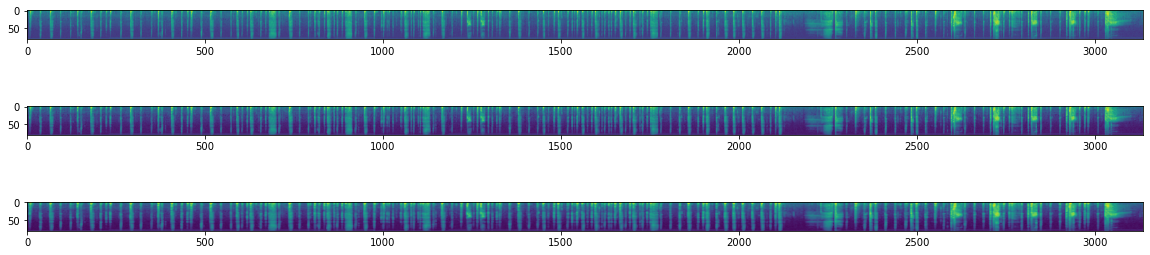

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(20, 5))
axs[0].imshow(spects[0])
axs[1].imshow(spects[1])
axs[2].imshow(spects[2])


In [4]:
def get_label_vector(times, onset_times, fuzzy=False):
    a = np.reshape(onset_times, (-1,1))
    b = np.reshape(times, (1,-1))
    onset_onehot = np.sum(np.abs(a - b) < HOP/(2*sr), 0)
    onset_wide = np.sum(np.abs(a - b) < 3*HOP/(2*sr), 0)
    onset_fuzzy = 0.25*onset_wide + 0.25*onset_onehot
    print("Sum of onehot: ", np.sum(onset_onehot))
    print("Len of onset times: ", len(onset_times))
    #fig, axs = plt.subplots(3, 1, figsize=(20,1))
    #axs[0].imshow(np.reshape(onset_onehot[:200], (1,200)))
    #axs[1].imshow(np.reshape(onset_wide[:200], (1,200)))
    #axs[2].imshow(np.reshape(onset_fuzzy[:200], (1,200)))
    
    if fuzzy: 
        return onset_fuzzy
    else:
        return onset_onehot
    



In [27]:
frame_dir = '../datasets/beatboxset1/frames/'
label_dir = '../datasets/beatboxset1/Annotations_DR/'
audio_dir = '../datasets/beatboxset1/wav/'
HOP = 440
sr = 44100
switch = False
N_MARGIN = 7
for file in os.listdir(audio_dir):
    if file in ["putfile_dbztenkaichi.wav", "callout_azeem.wav"]:
        continue
        
    print(file)
    file_id = file[:-4]
    frame_name = frame_dir + file_id + ".pickle"
    label_name = label_dir+file_id+".csv"
    audio_name  = audio_dir + file
    
    # Get audio
    audio = tfio.audio.AudioIOTensor(audio_name)
    length = len(audio)/sr
    
    # Get label vector
    with open(frame_name, 'rb') as handle:
        new_spect = np.array(pickle.load(handle))
        print(new_spect.shape)
    times = np.arange(0, length, HOP/sr)
    print("Audio clip defined from {:.3f} s to {:.3f} s".format(0, length))
    print("With a feature frequency of {:.3f} s this yields {} features".format(HOP/sr, len(times)))
    onset_times = genfromtxt(label_name, delimiter=',')[:,0]
    print("Onsets start at {} and end at {}".format(onset_times[0], onset_times[-1]))
    labels = get_label_vector(times, onset_times, fuzzy=False)[N_MARGIN:-N_MARGIN-1]
    print(labels.shape)
    print()
    if switch:
        big_data = np.concatenate((big_data, new_spect), axis=0)
        big_labels = np.concatenate((big_labels, labels))
    else:
        big_data = new_spect
        big_labels = labels
        switch = True

snare_hex.wav
(1227, 80, 15, 3)
Audio clip defined from 0.000 s to 12.388 s
With a feature frequency of 0.010 s this yields 1242 features
Onsets start at 0.528979591 and end at 11.604172335
Sum of onehot:  46
Len of onset times:  46
(1227,)

callout_Turn-Table.wav
(2993, 80, 15, 3)
Audio clip defined from 0.000 s to 30.005 s
With a feature frequency of 0.010 s this yields 3008 features
Onsets start at 0.280090702 and end at 29.364535147
Sum of onehot:  129
Len of onset times:  129
(2993,)

callout_luckeymonkey.wav
(3766, 80, 15, 3)
Audio clip defined from 0.000 s to 37.721 s
With a feature frequency of 0.010 s this yields 3781 features
Onsets start at 0.455782312 and end at 36.789795918
Sum of onehot:  211
Len of onset times:  211
(3766,)

battleclip_daq.wav
(5612, 80, 15, 3)
Audio clip defined from 0.000 s to 56.135 s
With a feature frequency of 0.010 s this yields 5627 features
Onsets start at 0.0 and end at 54.251972789
Sum of onehot:  354
Len of onset times:  354
(5612,)

callout_P

In [29]:
print(big_data.shape, big_labels.shape)

(56455, 80, 15, 3) (56455,)


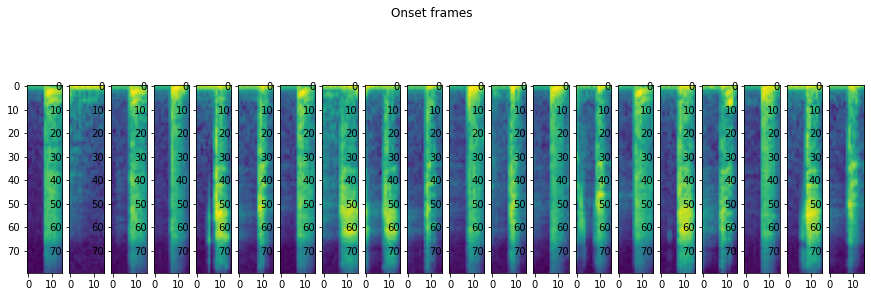

In [30]:
fig, axs = plt.subplots(1, 20, figsize=(15, 5))
fig.suptitle("Onset frames")
for i in range(20):
    axs[i].imshow(big_data[np.where(big_labels>=0.5)][i,:,:,0])


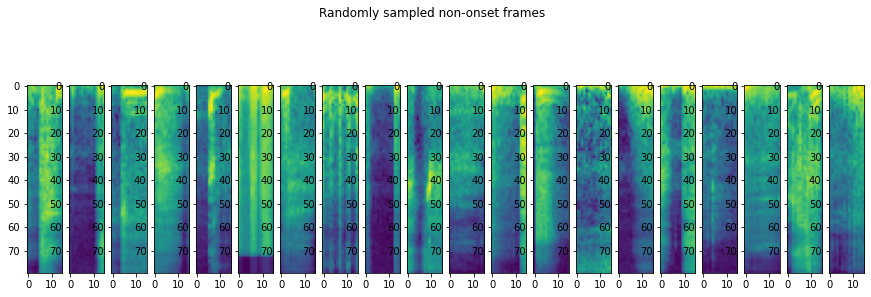

In [21]:
fig, axs = plt.subplots(1, 20, figsize=(15, 5))
fig.suptitle("Randomly sampled non-onset frames")
ss = big_data[np.where(big_labels==0)]
r = np.random.randint(0, high=len(ss), size=20)
for i in range(len(r)):
    
    axs[i].imshow(ss[r[i],:,:,0])

In [31]:
from sklearn.model_selection import train_test_split

n_samples, y_dim, x_dim, n_channels = big_data.shape 

X_train, X_test, y_train, y_test = train_test_split(
    big_data, big_labels, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.33, random_state=42)

# Normalize
resh_train = np.reshape(X_train, (len(X_train)*15,80,3))
mean_train = resh_train.mean(0).reshape((1,80,1,3))
std_train = resh_train.std(0).reshape((1,80,1,3))

X_train = (X_train - mean_train)/std_train
X_val = (X_val - mean_train)/std_train
X_test = (X_test - mean_train)/std_train

In [32]:
train_onsets = np.sum(y_train)
sets = ["Train", "Val", "Test"]
y_vecs = [y_train, y_val, y_test]
X_vecs = [X_train, X_val, X_test]
print("Set \t Frames  \t Onset ratio")
print("--------------------------")
[print("{} \t {} \t {} \t {:.3f}".format(
    set_name,
    len(X_vec),
    len(y_vec),
    np.sum(y_vec)/len(y_vec)
)) for (set_name, X_vec, y_vec) in zip(sets, X_vecs, y_vecs)]

Set 	 Frames  	 Onset ratio
--------------------------
Train 	 47986 	 47986 	 0.052
Val 	 5674 	 5674 	 0.053
Test 	 2795 	 2795 	 0.054


[None, None, None]

In [60]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(y_dim, x_dim, n_channels)),
    tf.keras.layers.Reshape((x_dim, y_dim, n_channels)),
    tf.keras.layers.Conv2D(
        activation = 'relu',
        filters = 10,
        kernel_size = (7,3),
        strides = 1
    ),
    tf.keras.layers.MaxPooling2D(
         pool_size=(1, 3), 
            strides=(1,3)
    ),
    tf.keras.layers.Conv2D(
        activation = 'relu',
        filters = 20,
        kernel_size = (3,3),
        strides = 1
    ),  
    tf.keras.layers.MaxPooling2D(
         pool_size=(1, 3), 
            strides=(1,3)
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'sigmoid'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(y_dim, x_dim, n_channels)),
    tf.keras.layers.Reshape((x_dim, y_dim, n_channels)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 15, 80, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 78, 10)         640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 26, 10)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 24, 20)         1820      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 8, 20)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1120)             

In [62]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [63]:
history = model.fit(
    x=X_train, 
    y=y_train,
    validation_data=(X_val, y_val),
    epochs = 1,
    batch_size = 128
)

375/375 [==============================] - 30s 73ms/step - loss: 0.1406 - accuracy: 0.9522 - val_loss: 0.1000 - val_accuracy: 0.9630


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [64]:
model.evaluate(x=X_test, y=y_test)

88/88 [==============================] - 1s 12ms/step - loss: 0.1106 - accuracy: 0.9564


[0.11056188493967056, 0.9563506245613098]

## Audio analysis

In [65]:
audio = tfio.audio.AudioIOTensor('../DoReMir/initslurtest_vn/initslurtest_vn_wav/slurtest04.wav')
audio_tensor = tf.squeeze(audio[:], axis=[-1])
audio_tensor = tf.cast(audio_tensor, tf.float32)/np.max(audio_tensor)

In [66]:
with open('../DoReMir/initslurtest_vn/spectrogram/slurtest04.pickle', 'rb') as handle:
    spects=pickle.load(handle)


In [67]:
onset_times = genfromtxt('../DoReMir/initslurtest_vn/initslurtest_vn_annotations/04.txt', delimiter=',')
print(onset_times)
times = np.arange(0, len(audio_tensor)/44100, 440/44100)
labels = get_label_vector(times, onset_times, fuzzy=False)

[ 0.458     0.87507   0.988     1.149     1.457     1.578     1.737
  2.007     2.157     2.309     2.587     2.707     2.885     3.198
  3.317     3.468     3.801607  3.897     4.029     4.337     4.462946
  4.607     4.907     5.027     5.228     5.538412  5.637     5.790923
  6.07      6.18      6.347     6.641     6.737     6.921211  7.217
  7.334849  7.517     7.798     7.897     8.056309  8.227055  8.368
  8.476     8.627     8.908     9.031     9.207     9.48      9.587
  9.787    10.367    10.707    10.815    11.       11.277    11.386
 11.528    11.806    11.907    12.063    12.357    12.458    12.623154
 12.927    13.027    13.196    13.497    13.587    13.738    14.017
 14.127    14.288    14.577    14.697    14.867   ]
Sum of onehot:  75
Len of onset times:  75


In [68]:
with open('../DoReMir/initslurtest_vn/frames/slurtest04.pickle', 'rb') as handle:
    frames=pickle.load(handle)
print(frames.shape)

(1585, 80, 15, 3)


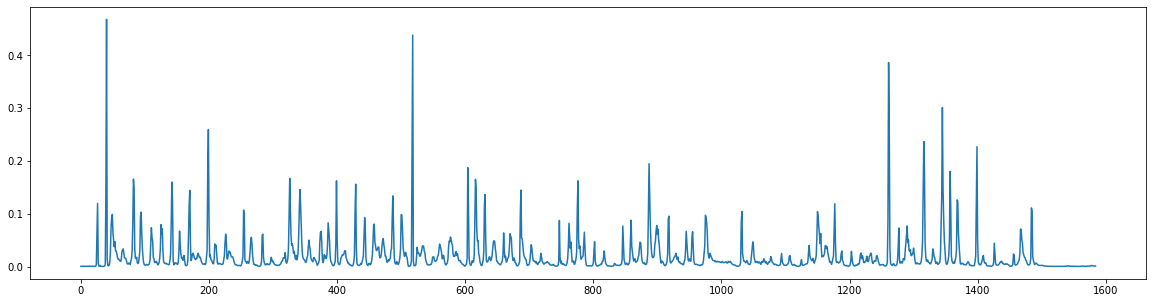

59


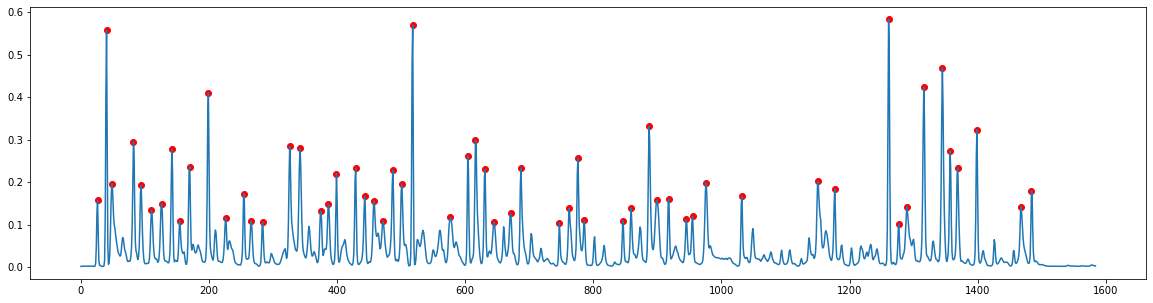

In [74]:
from scipy.signal import find_peaks
from librosa.util import peak_pick

pred_onsets = model.predict(frames)[:,0]
plt.figure(figsize=(20,5))
plt.plot(pred_onsets)
plt.show()

kernel_size = 5
smoothed = np.convolve(pred_onsets, np.hamming(kernel_size), mode='same')
plt.figure(figsize=(20,5))
plt.plot(smoothed)

peaks, _ = find_peaks(smoothed, height=0.1)
print(len(peaks))
for index in range(len(peaks)): 
    
    plt.scatter(x=peaks[index], y=smoothed[peaks[index]], c="red")

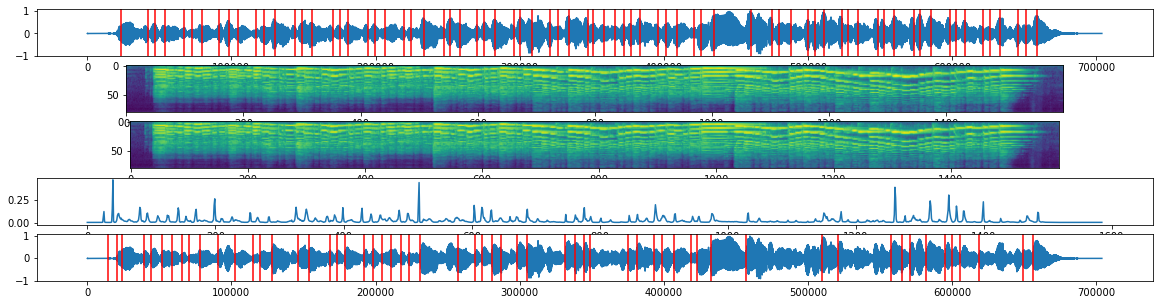

In [75]:
fig, axs = plt.subplots(5, 1, figsize=(20,5))
axs[0].plot(audio_tensor.numpy())
for index in range(len(labels)):
    if labels[index]>0.5:    
        axs[0].axvline(x=HOP*(index+7), c="red")
axs[0].set_autoscale_on(False)

axs[1].imshow(spects[0])
axs[1].set_autoscale_on(False)

axs[2].imshow(np.transpose(frames[:,:,8,0]))
axs[2].set_autoscale_on(False)

axs[3].plot(pred_onsets[pred_onsets>-50])
axs[4].plot(audio_tensor.numpy())
for index in range(len(peaks)):    
    axs[4].axvline(x=HOP*(peaks[index]+7), c="red")

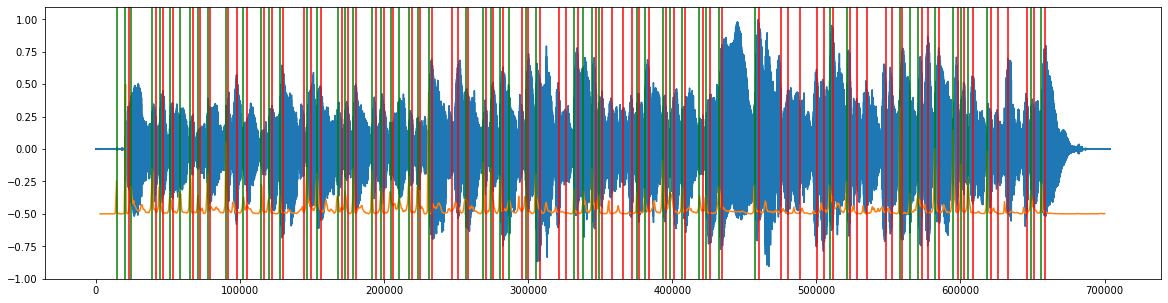

In [76]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(audio_tensor)), audio_tensor.numpy())
a = np.max(pred_onsets)
b = np.min(pred_onsets)
pred_onsets_scaled = (pred_onsets-((a+b)/2))/(a-b)
plt.plot(np.arange(7*440,len(audio_tensor)-8*440, 440), pred_onsets_scaled)
for index in range(len(labels)):
    if labels[index]>0.5:    
        plt.axvline(x=HOP*(index+7), c="red")
        
for index in range(len(peaks)): 
    plt.axvline(x=HOP*(peaks[index]+7), c="green")

In [78]:
f = open("../DoReMir/initslurtest_vn/model-output/bockmodel01-beatbox-slurtest04.txt", "w")
for i in range(len(peaks)):
    f.write(str(np.round((peaks[i]+7)*440/44100, decimals=2))+ "\n")
f.close()